Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

    1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
    2- Qual o Número de Títulos Por Gênero?
    3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
    4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
    5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
    6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
    7- Qual a Relação Entre Duração e Gênero?
    8- Qual o Número de Filmes Produzidos Por País?
    9- Quais São os Top 10 Melhores Filmes?
    10- Quais São os Top 10 Piores Filmes?


In [1]:
#Intala o pacote
!pip install -q imdb-sqlite

#https://pypi.org/project/pycountry
!pip install -q pycountry

In [2]:
#Imports
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

# Carregando os Dados

In [3]:
%%time
!imdb-sqlite

2022-02-13 12:44:43,687 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 5.32 ms, sys: 23.5 ms, total: 28.8 ms
Wall time: 715 ms


In [4]:
#Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [5]:
#Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'",conn)

In [6]:
#Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [7]:
#Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
#Convertendo o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [9]:
#Percorendo a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




# 1 - Quais São as Categorias de Filmes Mais Comuns no IMDB?

In [10]:
# Cria a consulta SQL
consulta1 = '''
            SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type
            '''

In [11]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [12]:
#Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,601855
1,short,855747
2,tvEpisode,6501575
3,tvMiniSeries,42079
4,tvMovie,134921
5,tvPilot,2
6,tvSeries,220998
7,tvShort,10457
8,tvSpecial,35916
9,video,257557


In [13]:
# Calculando o percentual para cda tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum())*100

In [14]:
#Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,601855,6.924629
1,short,855747,9.845778
2,tvEpisode,6501575,74.803728
3,tvMiniSeries,42079,0.484139
4,tvMovie,134921,1.552331
5,tvPilot,2,0.000023
6,tvSeries,220998,2.542688
7,tvShort,10457,0.120313
8,tvSpecial,35916,0.413231
9,video,257557,2.963316


In [15]:
# Criando um gráfico com apenas 4 categorias:
# As 3 categorias com mais titulos e 1 categoria com todo o restante

#Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual']<5]['COUNT'].sum()

#Grava o percentual
others['percentual'] = resultado1[resultado1['percentual']<5]['percentual'].sum()

#Ajuste o nome
others['type'] = 'others'

In [16]:
#Visualiza
others

{'COUNT': 732335, 'percentual': 8.425864222473605, 'type': 'others'}

In [17]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual']>5]

In [18]:
#Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [19]:
#Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [20]:
#Visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6501575,74.803728
1,short,855747,9.845778
3,others,732335,8.425864
0,movie,601855,6.924629


In [21]:
#Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2))+'%'+']' for i in resultado1.index]

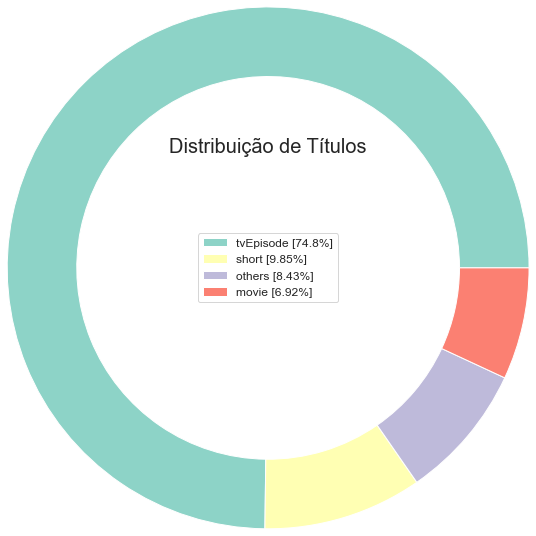

In [22]:
#Plot

#Mapa de cores
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

#Cria a figura
f = plt.figure()

#Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

# 2 - Qual o Número de Títulos Por Gênero?

In [23]:
#Cria a consulta SQL
consulta2 = '''
            SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres
            '''

In [24]:
#Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [25]:
#Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13806
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1447,"Thriller,Western",42
1448,War,1285
1449,"War,Western",14
1450,Western,5091


In [26]:
# Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [27]:
#Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [28]:
# Vamo criar um vetor usando expressão regular para filtrar as strings

#https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [29]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [30]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [31]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [32]:
# Retorna generos únicos
generos_unicos = vetor.get_feature_names()

In [33]:
#Cria o dataframe de generos
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [34]:
#Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452 entries, 0 to 1451
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1452 non-null   int64
 1   adult        1452 non-null   int64
 2   adventure    1452 non-null   int64
 3   animation    1452 non-null   int64
 4   biography    1452 non-null   int64
 5   comedy       1452 non-null   int64
 6   crime        1452 non-null   int64
 7   documentary  1452 non-null   int64
 8   drama        1452 non-null   int64
 9   family       1452 non-null   int64
 10  fantasy      1452 non-null   int64
 11  film-noir    1452 non-null   int64
 12  game-show    1452 non-null   int64
 13  history      1452 non-null   int64
 14  horror       1452 non-null   int64
 15  music        1452 non-null   int64
 16  musical      1452 non-null   int64
 17  mystery      1452 non-null   int64
 18  n            1452 non-null   int64
 19  news         1452 non-null   int64
 20  reality-

In [35]:
#Drop da coluna n
generos = generos.drop(columns = 'n', axis=0)

In [36]:
#Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [37]:
#Visualiza
generos_percentual.head(10)

drama          18.181818
comedy         16.873278
documentary    15.840220
adventure      14.807163
action         14.393939
romance        13.360882
crime          13.085399
mystery        12.534435
thriller       12.327824
fantasy        12.190083
dtype: float64

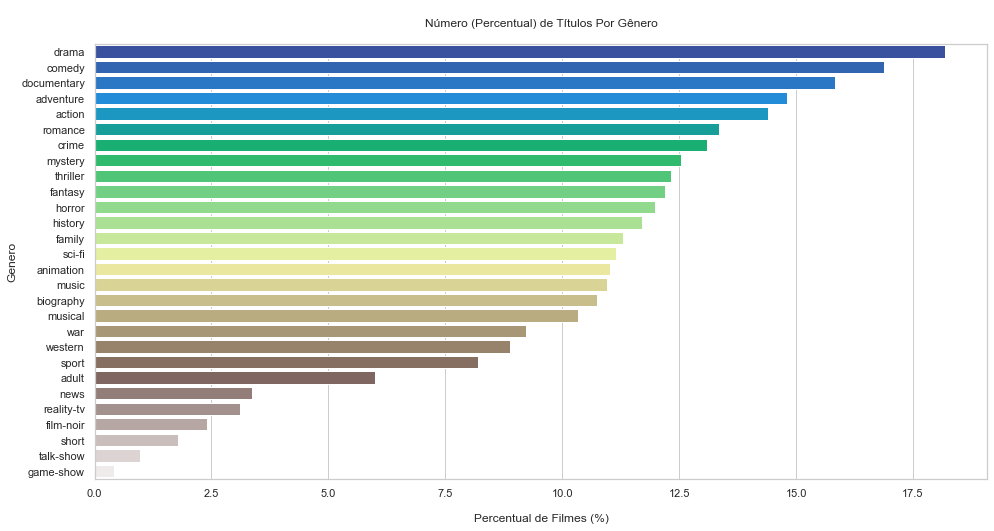

In [38]:
#Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Genero')
plt.xlabel("\nPercentual de Filmes (%)")
plt.title("\nNúmero (Percentual) de Títulos Por Gênero\n")
plt.show()

# 3 - Qual a Mediana de Avaliação dos Filmes Por Gênero?

In [39]:
#Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            '''

In [40]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [41]:
#Visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
274698,5.8,Thriller
274699,6.4,"Drama,History"
274700,3.8,"Adventure,History,War"
274701,8.3,Drama


In [10]:
#Criando uma função para retornar os generos
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [43]:
#Aplica a função
generos_unicos = retorna_generos(resultado3)

In [44]:
#Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [45]:
#Cria listas vazias
genero_counts = []
genero_ratings = []

In [46]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [47]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [48]:
#Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28488,5.8
1,adult,4275,5.9
2,adventure,17277,6.0
3,animation,4718,6.6
4,biography,8283,7.0
5,comedy,68084,6.0
6,crime,23468,6.1
7,documentary,40741,7.3
8,drama,121689,6.3
9,family,10624,6.3


In [49]:
#Drop do indice 18 (news)
#Não queremos essa informação como genero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [50]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

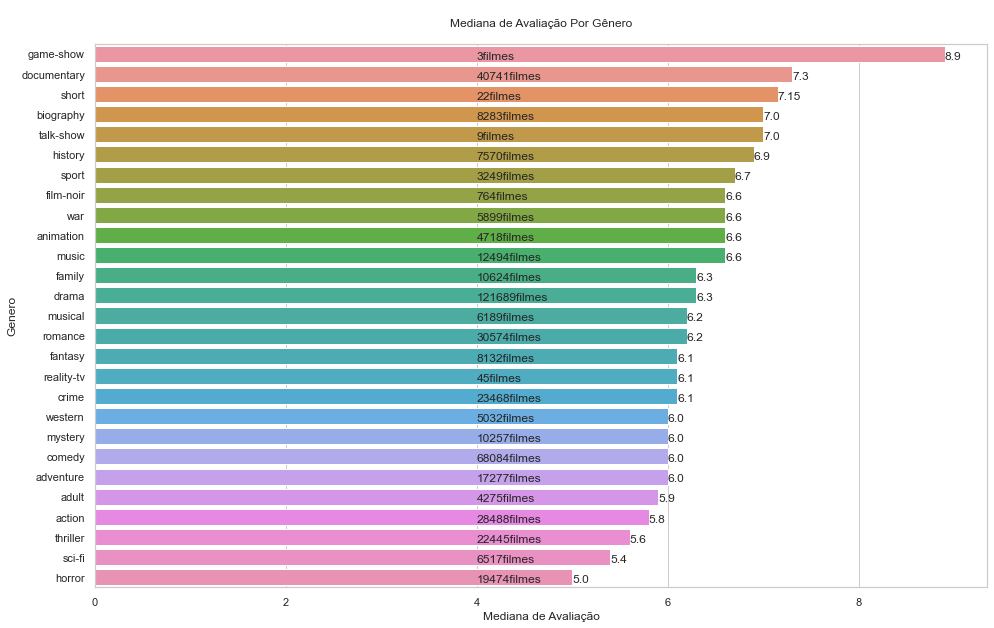

In [51]:
#Plot

#Figure
plt.figure(figsize = (16,10))

#Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

#Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0,
             i + 0.25,
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + "filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))
    
plt.ylabel('Genero')
plt.xlabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

# 4 - Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

In [52]:
#Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM
            ratings JOIN titles ON ratings.title_id = titles.title_id
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            '''

In [53]:
# REsultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [54]:
display(resultado4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
274698,9.4,2022
274699,7.0,2022
274700,3.6,2022
274701,4.8,2022


In [55]:
#Calculando a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [56]:
type(ratings)

list

In [57]:
ratings[1:10]

[4.5, 3.85, 5.85, 4.6, 3.5, 4.6, 5.4, 4.5, 3.6]

In [58]:
#Lista de Anos
anos = list(set(resultado4['premiered']))

In [59]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

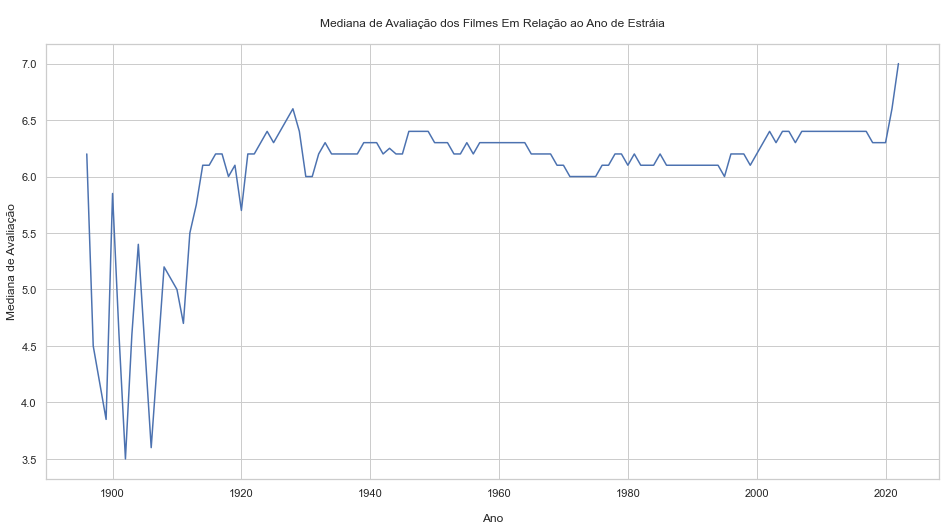

In [60]:
#plot

plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estráia\n')
plt.show()

# 5 - Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

In [11]:
#Consulta SQL
consulta5 = '''
            SELECT genres FROM titles
            '''

In [12]:
#Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [13]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8691507,"Action,Drama,Family"
8691508,"Action,Drama,Family"
8691509,"Action,Drama,Family"
8691510,Short


In [14]:
#Retorna generos únicos
generos_unicos = retorna_generos(resultado5)

In [15]:
#Visualiza o resultado
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [18]:
# Fzendo a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [20]:
#Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [21]:
#Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

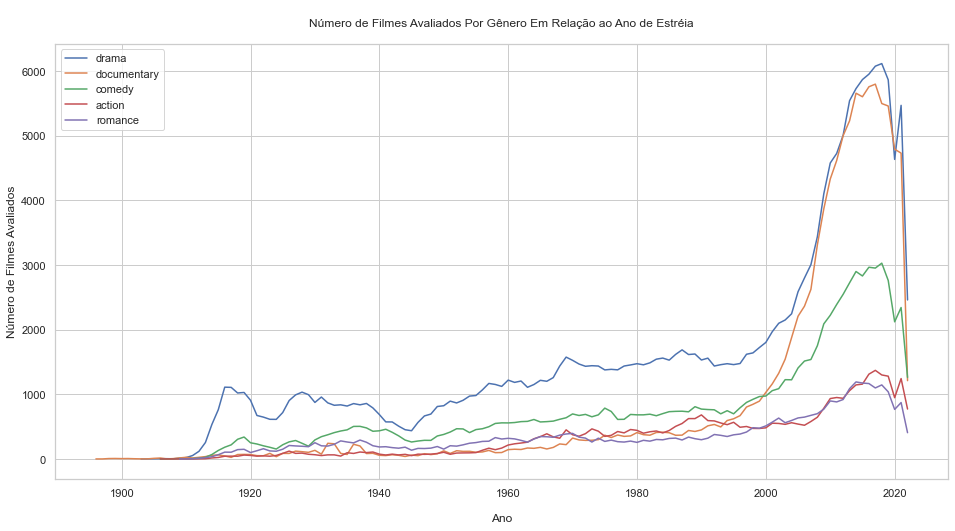

In [22]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

# 6 - Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis

In [23]:
#Consulta SQL
consulta6 = '''
            SELECT runtime_minutes Runtime
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''

In [24]:
#Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [25]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
378400,123
378401,57
378402,100
378403,116


In [26]:
#Loop para calculo dos percentis
for i in range(101):
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [27]:
#Reafazendo a consulta e retornando o filme com maior duração
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''

In [28]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [29]:
resultado6

,Runtime,primary_title
0,51420,Logistics


# 7 - Qual a Relação Entre Duração e Gênero?

In [30]:
#Consulta SQL
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres
            FROM titles
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''

In [32]:
#Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [33]:
#Retorna generos unicos
generos_unicos = retorna_generos(resultado7)

In [34]:
#Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [35]:
# Calcula duração por gênero
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [38]:
#Prepara O DataFrame
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [39]:
#Remove indice 18(news)
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

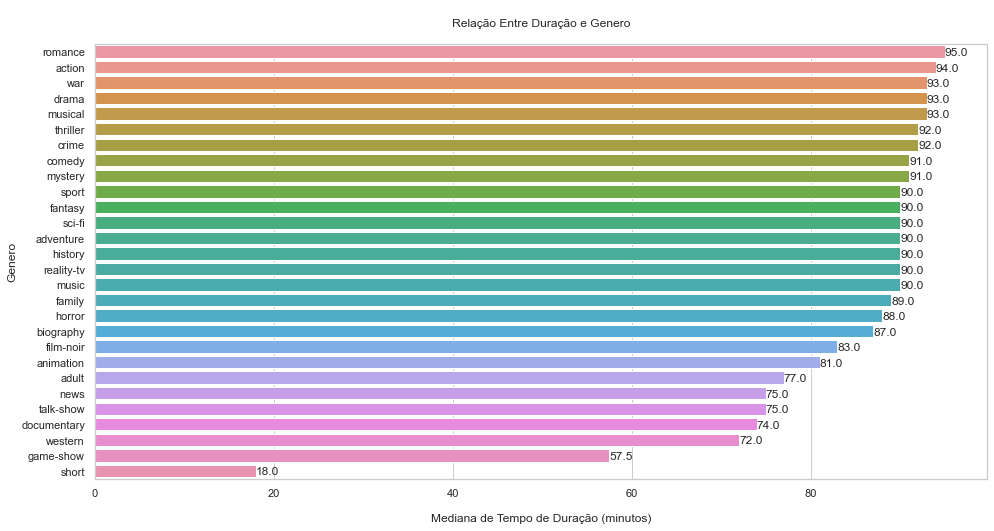

In [40]:
#Plot

#Tamanho da figura
plt.figure(figsize = (16,8))

#Barplot
sns.barplot( y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

#Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))
    
plt.ylabel('Genero')
plt.xlabel('\nMediana de Tempo de Duração (minutos)')
plt.title('\nRelação Entre Duração e Genero\n')
plt.show()

# 8 - Qual o Número de Filmes Produzidos Por País?

In [44]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            '''

In [45]:
#Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [46]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,4847
2,AF,109
3,AG,12
4,AL,1263
...,...,...
229,YUCS,153
230,ZA,3161
231,ZM,15
232,ZRCD,2


In [47]:
# Shape
resultado8.shape[0]

234

In [48]:
#Lista auxiliares
nomes_paises = []
contagem = []

In [54]:
# Loop para obter o país de acordo com a região
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [55]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [56]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [57]:
#Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,306746
65,United Kingdom,157734
96,Japan,90493
63,France,83796
89,India,79051
32,Canada,75698
47,Germany,69628
93,Italy,64886
58,Spain,64600
26,Brazil,64482


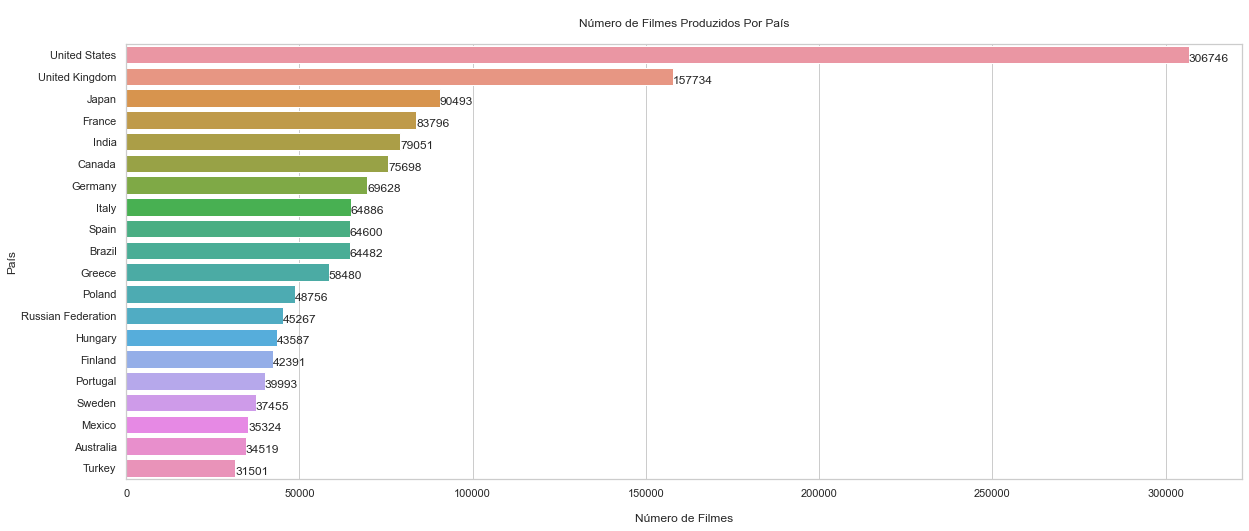

In [58]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# 9 - Quais São os Top 10 Melhores Filmes?

In [59]:
#Consulta SQL
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM
            titles JOIN ratings
            ON titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10
            '''

In [60]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [61]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,Jai Bhim,"Crime,Drama,Mystery",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.1
5,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
6,Mirror Game,"Crime,Mystery,Thriller",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


# 10 - Quais São os Top 10 Piores Filmes?

In [62]:
#Consulta SQL
consulta10 = '''
             SELECT primary_title AS Movie_Name, genres, rating
             FROM
             titles JOIN ratings
             ON titles.title_id = ratings.title_id
             WHERE titles.type = 'movie' AND ratings.votes >= 25000
             ORDER BY rating ASC
             LIMIT 10
             '''

In [63]:
#Rsultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [64]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Reis,"Biography,Drama",1.4
4,The Cost of Deception,"Crime,Drama,History",1.5
5,Justin Bieber: Never Say Never,"Documentary,Music",1.6
6,Manos: The Hands of Fate,Horror,1.8
7,Radhe,"Action,Crime,Thriller",1.8
8,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
